<a href="https://colab.research.google.com/github/ahmedelraei/stock-prices-predict/blob/main/Stock_Prices_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas_datareader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


# Pre-processing Data

In [53]:
ticker = "META"

start = dt.datetime(2008,1,1)
end = dt.datetime(2022,1,1)

data = pandas_datareader.DataReader(ticker, "yahoo", start, end)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-27,347.869995,338.010010,338.850006,346.179993,17795000,346.179993
2021-12-28,352.709991,345.200012,346.630005,346.220001,16637600,346.220001
2021-12-29,349.690002,341.640015,346.910004,342.940002,10747000,342.940002
2021-12-30,347.230011,343.220001,344.000000,344.359985,10593300,344.359985
2021-12-31,343.440002,336.269989,343.019989,336.350006,12870500,336.350006


# Training Model

In [54]:
prediction_days = 90

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
73/73 [==============================] - 15s 121ms/step - loss: 0.0108
Epoch 2/25
73/73 [==============================] - 9s 120ms/step - loss: 0.0026
Epoch 3/25
73/73 [==============================] - 10s 136ms/step - loss: 0.0025
Epoch 4/25
73/73 [==============================] - 11s 148ms/step - loss: 0.0020
Epoch 5/25
73/73 [==============================] - 11s 152ms/step - loss: 0.0019
Epoch 6/25
73/73 [==============================] - 10s 130ms/step - loss: 0.0022
Epoch 7/25
73/73 [==============================] - 11s 145ms/step - loss: 0.0019
Epoch 8/25
73/73 [==============================] - 9s 126ms/step - loss: 0.0021
Epoch 9/25
73/73 [==============================] - 9s 121ms/step - loss: 0.0017
Epoch 10/25
73/73 [==============================] - 9s 120ms/step - loss: 0.0016
Epoch 11/25
73/73 [==============================] - 10s 135ms/step - loss: 0.0015
Epoch 12/25
73/73 [==============================] - 9s 121ms/step - loss: 0.0015
Epoch 13/25
73/73 

# Testing The Model

In [59]:
test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()
test_data = pandas_datareader.DataReader(ticker, "yahoo", test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

7/7 [==============================] - 0s 32ms/step


# Predicting Next Day

In [58]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = scaler.inverse_transform(model.predict(real_data))
prediction[0][0]

1/1 [==============================] - 0s 27ms/step


99.09978

# Plotting The Results

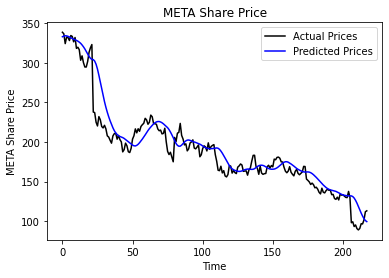

In [60]:
plt.plot(actual_prices, color="black", label="Actual Prices")
plt.plot(predicted_prices, color="blue", label="Predicted Prices")
plt.title(f"{ticker} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{ticker} Share Price")
plt.legend()
plt.show()